In [4]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np;

def standardplot(xl,yl,ti):
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(ti)
    plt.grid(lw = 0.5)

# ZABR implementation in Python

See paper by Andreasen & Huge: http://janroman.dhis.org/finance/SABR/ZABR%20Andreasen.pdf.
This is an implementation of the model to produce the volatility smile. The beauty about SABR model is the closed form solution for Black's implied volatilty with closed analytical formula. The ZABR model is presented in Andreasen & Huge 2011 is that straight-forward as it includes a ODE step tom compute Black's implied volatility but this is still signicinalty easier instead of heavy simulation work to compute Black's impliev volatilty (IV).

The function input parameters are
   - S: At-the-money 
   - K_data: a list of three elemets: lower strike, upper strike, difference strike
   - alpha, beta , rho , epsi , gamma: model paramaters
   - (iv_norm: If false then the function returns the log-normal implied volatility (Black's). The normal vol has not yet been implemented)
 
 The return value of the function is a matrix (numpy array) with first columns being set of strikes and second column being corresponding IV

In [5]:
def zabr_smile( S, K_data, alpha, beta , rho , epsi , gamma, iv_norm = False):
    # this generates the implied volatilities for a given data set 
    # the notation is the one given in the original article by Andreasen & Huge
    # the IV_norm should indicate whether it is normal vol or log-normal
    # but normal has not been implemented yet
    Kl = K_data[0]; Ku =  K_data[1]; delta =  K_data[2]
    
    if abs(Kl- Ku)<0.0000001:
        K = np.array([Kl]) # strike        
    else:
        K = np.linspace(Kl,Ku, int((Ku-Kl)/delta) +1 )  # strike        
    
    nK = len(K)
    nu = np.zeros((nK));
    impvol = np.zeros((nK));
    f = np.zeros(len(K));   # f(y) and not f

    adjepsi = epsi*alpha**(1-gamma) ## to match SABR's
    
    
    if beta == 1:
        y = alpha**(gamma-2)*np.log(S/K)
    else:
        y = (S**(1-beta)-K**(1-beta))/(1-beta)*alpha**(gamma-2);
    
    def A(y): return 1+(gamma-2)**2*adjepsi**2*y**2+2*rho*(gamma-2)*adjepsi*y 
    def B(y): return 2*rho*(1-gamma)*adjepsi+2*(1-gamma)*(gamma-2)*adjepsi**2*y;
    C = (1-gamma)**2*adjepsi**2;
    
    f0 = 0; 
    y0 = 0;
    
    # analytical integral value
    for i in range(nK):
        if K[i]==S:
            f[i] = 0;
            atm_pos = i 
        else:
            def odefun(t,f):return 0.5*(-B(t)*f+np.sqrt(B(t)**2*f**2-4*A(t)*(C*f**2-1)))/A(t);
            sol = solve_ivp(odefun, [y0,y[i]], [f0] )
            f[i]   = sol.y[0,-1]
            f0      = f[i]
            y0      = y[i]
#            print(i)
    x               = alpha**(1-gamma)*f;
    nu              = (S-K)/x
    nubar           = np.log(S/K)/x
    

    for i in range(nK):
        if K[i]==S:
            atm_pos = i
            nu[atm_pos]     = S**beta*alpha;
            nubar[atm_pos]  = alpha*S**(beta-1);
    
    ret     = np.zeros((2,nK))
    ret[0]  = K
    if iv_norm == False:        
        ret[1]  = nubar
    else:
        ret[1]  = nubar        
    return ret

The results for some given paramaters are shown below. The greek letters are the same as in the article. $\gamma=1$ yields the same model as SABR.

<ipython-input-5-beb798b62ab6>:46: RuntimeWarning: invalid value encountered in true_divide
  nu              = (S-K)/x
<ipython-input-5-beb798b62ab6>:47: RuntimeWarning: invalid value encountered in true_divide
  nubar           = np.log(S/K)/x
<ipython-input-5-beb798b62ab6>:46: RuntimeWarning: invalid value encountered in true_divide
  nu              = (S-K)/x
<ipython-input-5-beb798b62ab6>:47: RuntimeWarning: invalid value encountered in true_divide
  nubar           = np.log(S/K)/x
<ipython-input-5-beb798b62ab6>:46: RuntimeWarning: invalid value encountered in true_divide
  nu              = (S-K)/x
<ipython-input-5-beb798b62ab6>:47: RuntimeWarning: invalid value encountered in true_divide
  nubar           = np.log(S/K)/x
<ipython-input-5-beb798b62ab6>:46: RuntimeWarning: invalid value encountered in true_divide
  nu              = (S-K)/x
<ipython-input-5-beb798b62ab6>:47: RuntimeWarning: invalid value encountered in true_divide
  nubar           = np.log(S/K)/x


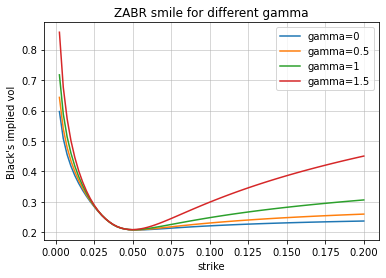

In [7]:
alpha = 0.0873; beta = 0.7;  # ZABR parameter                    
rho = -0.48; epsi =v= 0.47;    # ZABR parameter
gamma_ = [0,0.5,1,1.5]   # ZABR parameter
S = 0.0325; t = T = 10;          # derivative parameters                      
K_data =[0.0025, 0.2,0.0025]  # strikes


for i in range(len(gamma_)):
    run = zabr_smile( S, K_data, alpha, beta , rho , epsi , gamma_[i])
    plt.plot(run[0],run[1], label="gamma="+str(gamma_[i]))
plt.legend()
standardplot("strike", "Black's implied vol", "ZABR smile for different gamma")



(someday i'll fix the runtime warning. it does not have an impact on the final result.)